
# Online Retail — Pré-processamento e Clusterização

Este notebook conduz um fluxo completo de pré processamento e clusterização para o dataset **Online Retail (UCI)**:
1) **Carregamento e checagens iniciais**  
2) **Limpeza e engenharia de variáveis** (flags de cancelamento/ajuste, valor por linha, etc.)  

> Observações
> - Os métodos de clustering normalmente usam métricas que envolvem distância e minimiza a variância intra-cluster; por isso precisamos **padronizar** as features.  
> - O dataset contém registros **administrativos** (ex.: *Adjust bad debt*, *Bank charges*, **InvoiceNo** iniciando em `A` para ajustes e `C` para cancelamentos). Mantemos **flags** para transparência e **filtramos** para análises comerciais.

Link de acesso ao dataset: https://archive.ics.uci.edu/dataset/352/online+retail

In [89]:
#Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import os
import sys
import pandas as pd
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)
from dbscan import DBSCAN
from kmeans import KMeans
from kmedoids import KMedoids
from wardmethod import WardMethod
from expectationmaximization import ExpectationMaximization
import distance_metrics
from evaluationmetrics import EvaluationMetrics
from func_auxiliar import plot_algorithm_all_metrics, calculate_clustering_metrics, generate_synthetic_blobs, plot_algorithm_all_metrics_3d, plot_melhor_k_silhouette_and_sse, to_probability_simplex

In [2]:

FILE_PATH = r"/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/data/DatasetRaw/online_retail/Online Retail.xlsx"

# Leitura do Excel
df = pd.read_excel(FILE_PATH)

# Uniformização de nomes esperados
expected_cols = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
df = df[expected_cols]

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Remoção de linhas com CustomerID nulo | somente clientes identificados serão considerados
df = df.dropna(subset=['CustomerID'])

In [4]:
# Remoção de linhas com Quantity menor ou igual a zero | somente compras válidas serão consideradas cancelamentos não são consideradas
df = df[df['Quantity'] > 0]

In [5]:
# Remoção de linhas com UnitPrice menor ou igual a zero | brindes e ajustes não devem ser considerados
df = df[df['UnitPrice'] > 0]

In [6]:
#Criando coluna TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
# Remoção de linhas duplicadas
df = df.drop_duplicates()

In [8]:
df[['Quantity', 'UnitPrice', 'TotalPrice']].describe()

,Quantity,UnitPrice,TotalPrice
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,22.631500
std,180.492832,22.241836,311.099224
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


In [9]:
df['CustomerID'].nunique()

4338

In [10]:
# Conversão da coluna InvoiceDate para o tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
# Definindo a data de snapshot como o dia seguinte à última data presente no dataset
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [12]:
# Recency: dias desde a última compra de cada cliente
recency = (
    df.groupby('CustomerID')['InvoiceDate']
      .max()
      .reset_index()
      .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)
recency['Recency'] = (snapshot_date - recency['LastPurchaseDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# Frequency: número de faturas distintas por cliente
frequency = (
    df.groupby('CustomerID')['InvoiceNo']
      .nunique()
      .reset_index()
      .rename(columns={'InvoiceNo': 'Frequency'})
)

# Monetary: soma do valor total gasto por cliente
monetary = (
    df.groupby('CustomerID')['TotalPrice']
      .sum()
      .reset_index()
      .rename(columns={'TotalPrice': 'Monetary'})
)

# Juntar tudo em um único DataFrame RFM
rfm = (
    recency
    .merge(frequency, on='CustomerID')
    .merge(monetary, on='CustomerID')
    .set_index('CustomerID')
)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [93]:
# rfm: índice = CustomerID, colunas = Recency, Frequency, Monetary

scaler = MinMaxScaler()

rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

X = pd.DataFrame(
    rfm_scaled,
    index=rfm.index,
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
)

X.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled
CustomerID,,,
12346.0,0.871314,0.000000,0.275443
12347.0,0.002681,0.028846,0.015368
12348.0,0.198391,0.014423,0.006401
12349.0,0.048257,0.000000,0.006259
12350.0,0.828418,0.000000,0.001180


In [14]:
rfm_full = (
    rfm
    .join(X)  # adiciona Recency_scaled, Frequency_scaled, Monetary_scaled
)

rfm_full.head()

,Recency,Frequency,Monetary,Recency_scaled,Frequency_scaled,Monetary_scaled
CustomerID,,,,,,
12346.0,326,1,77183.60,0.871314,0.000000,0.275443
12347.0,2,7,4310.00,0.002681,0.028846,0.015368
12348.0,75,4,1797.24,0.198391,0.014423,0.006401
12349.0,19,1,1757.55,0.048257,0.000000,0.006259
12350.0,310,1,334.40,0.828418,0.000000,0.001180


In [15]:
X_jsd = to_probability_simplex(X)

In [ ]:
#Estudo do melhor k para K-Means
results_k = []
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmeans = KMeans(k=k, max_iterations=7000, metric_name='euclidean_distance')
    centroids_kmeans, clusters_kmeans = kmeans.fit(X)
    diffs = (X - centroids_kmeans[clusters_kmeans]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmeans)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Means"
    })
    

Convergiu na iteração 5
Convergiu na iteração 21
Convergiu na iteração 22
Convergiu na iteração 19
Convergiu na iteração 44
Convergiu na iteração 42
Convergiu na iteração 45
Convergiu na iteração 40
Convergiu na iteração 61


In [26]:
df_k_search = pd.DataFrame(results_k)
df_k_search

,k,sse_euclidean,silhouette,algoritmo
0,2,74.115508,0.722724,K-Means
1,3,40.833413,0.645018,K-Means
2,4,36.152238,0.650264,K-Means
3,5,22.695963,0.572344,K-Means
4,6,16.120427,0.560162,K-Means
5,7,14.515633,0.515062,K-Means
6,8,10.879395,0.470891,K-Means
7,9,9.506837,0.487983,K-Means
8,10,8.685207,0.425504,K-Means


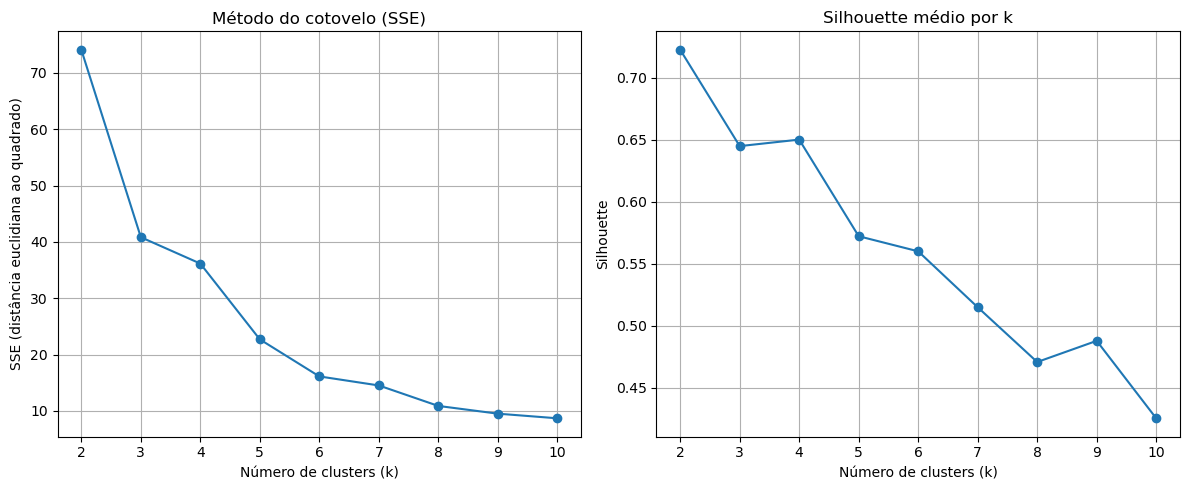

In [ ]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Means'])

In [ ]:
#Estudo do melhor k para K-medoids
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmedoids = KMedoids(k=k, max_iterations=7000, metric_name='euclidean_distance')
    centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
    diffs = (X - centroids_kmedoids[clusters_kmedoids]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmedoids)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Medoids"
    })
    

K-Medoids convergiu na iteração 6
K-Medoids convergiu na iteração 7
K-Medoids convergiu na iteração 12
K-Medoids convergiu na iteração 14
K-Medoids convergiu na iteração 6
K-Medoids convergiu na iteração 13
K-Medoids convergiu na iteração 44
K-Medoids convergiu na iteração 46
K-Medoids convergiu na iteração 47


In [ ]:
df_k_search = pd.DataFrame(results_k)
df_k_search

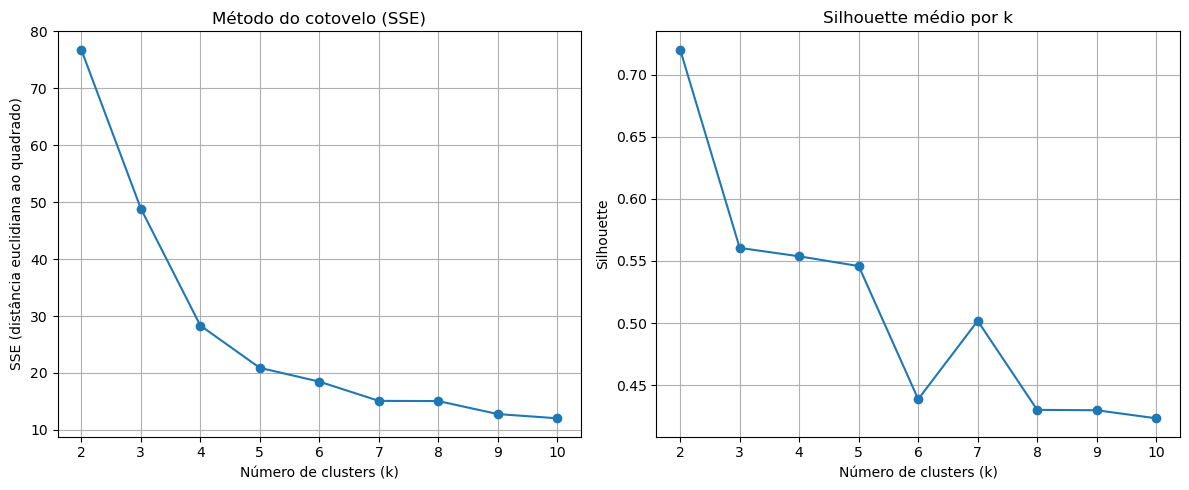

In [30]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Medoids'])

### Algoritmo: Kmeans

In [83]:
metrics = ['euclidean_distance', 'manhattan_distance', 'cosine_distance', 'mahalanobis_distance', 'jensen-shannon_distance']

In [ ]:
results_kmeans = []
plots_kmeans = {}

In [ ]:
# instaciando o KMeans
for metric_name in metrics:
    kmeans = KMeans(k=3, max_iterations=1000, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        centroids_kmeans, clusters_kmeans = kmeans.fit(X_jsd)
        runtime_kmeans = abs(time() - t0)
        results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=metric_name, runtime=runtime_kmeans, X=X_jsd, labels=clusters_kmeans))
        plots_kmeans[metric_name] = {
            "X": X_jsd,
            "labels": clusters_kmeans,
            "model": kmeans
        }
    else:
        t0 = time()
        centroids_kmeans, clusters_kmeans = kmeans.fit(X)
        runtime_kmeans = time() - t0
        results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))
        plots_kmeans[metric_name] = {
            "X": X,
            "labels": clusters_kmeans,
            "model": kmeans
        }
    
    print(f"KMeans com {metric_name} finalizado.")

Convergiu na iteração 18
KMeans com manhattan_distance finalizado.
Convergiu na iteração 9
KMeans com cosine_distance finalizado.
Convergiu na iteração 25
KMeans com jensen-shannon_distance finalizado.


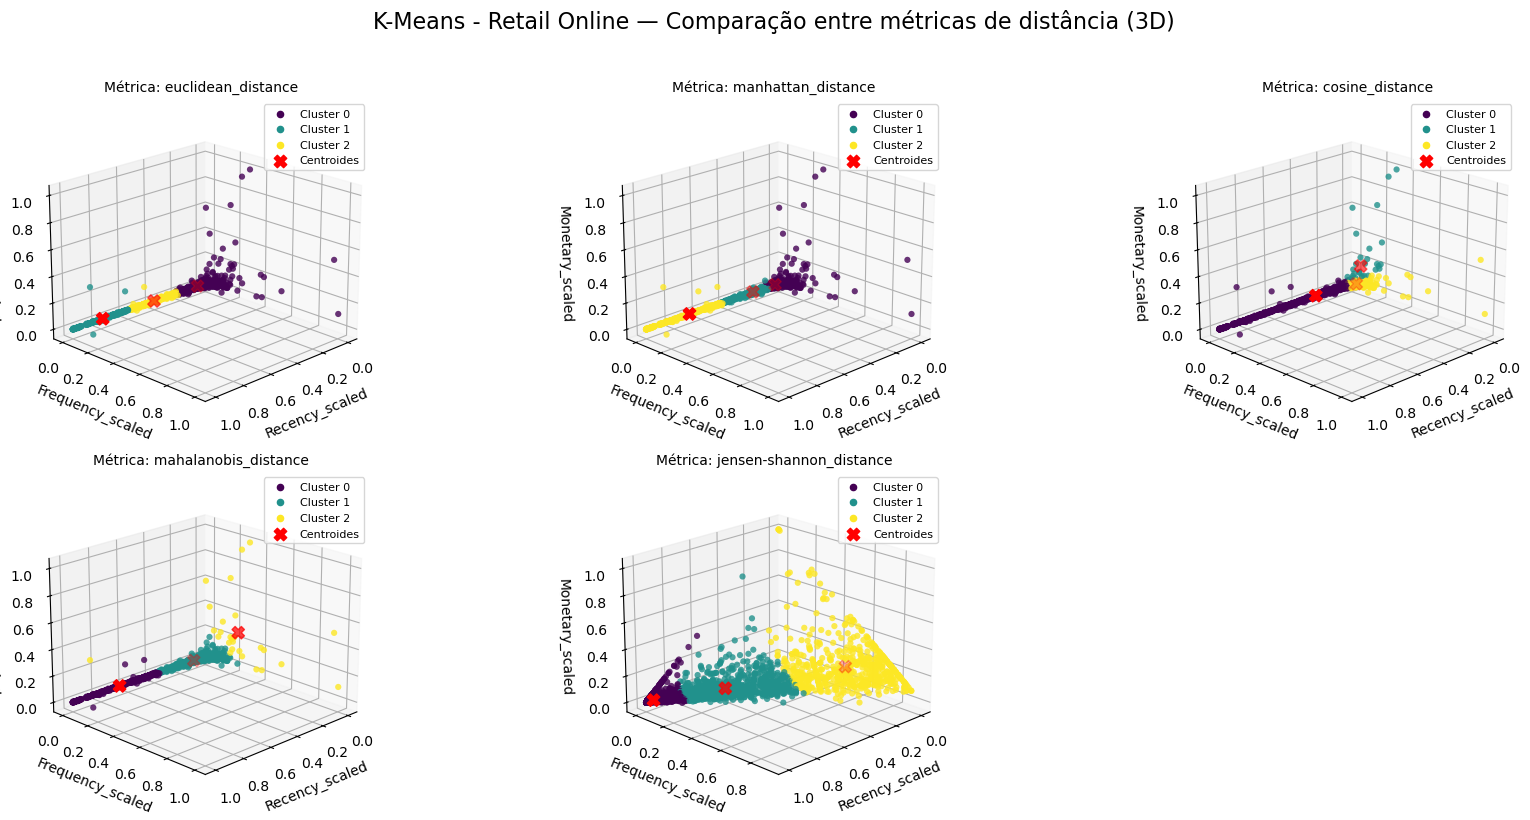

In [50]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmeans, algorithm_name="K-Means - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [55]:
#results_kmeans.pop()
df_results_kmeans = pd.DataFrame(results_kmeans)
df_results_kmeans

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Kmeans,euclidean_distance,3,1.059714,40.871909,0.644845,0.505071,14919.978650
1,Kmeans,mahalanobis_distance,3,1.008196,70.030733,0.701699,0.825255,7805.234166
2,Kmeans,manhattan_distance,3,0.548047,47.679788,0.557743,0.586410,12480.171829
3,Kmeans,cosine_distance,3,2.043190,245.702018,-0.089795,1.377482,674.958866
4,Kmeans,jensen-shannon_distance,3,10.809202,71.657975,0.685348,0.551275,16228.363534


In [56]:
labels_k_means_euclidean = plots_kmeans['euclidean_distance']["labels"]
labels_k_means_manhattan = plots_kmeans['manhattan_distance']["labels"]
labels_k_means_cosine = plots_kmeans['cosine_distance']["labels"]
labels_k_means_mahalanobis = plots_kmeans['mahalanobis_distance']["labels"]
labels_k_means_jsd = plots_kmeans['jensen-shannon_distance']["labels"]

rfm_k_means = rfm.copy()
rfm_k_means[f"cluster_k_means_euclidean"] = labels_k_means_euclidean
rfm_k_means[f"cluster_k_means_manhattan"] = labels_k_means_manhattan
rfm_k_means[f"cluster_k_means_cosine"] = labels_k_means_cosine
rfm_k_means[f"cluster_k_means_mahalanobis"] = labels_k_means_mahalanobis
rfm_k_means[f"cluster_k_means_jsd"] = labels_k_means_jsd
rfm_k_means.head()

,Recency,Frequency,Monetary,cluster_k_means_euclidean,cluster_k_means_manhattan,cluster_k_means_cosine,cluster_k_means_mahalanobis,cluster_k_means_jsd
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,2,0,2,0
12347.0,2,7,4310.00,0,0,2,1,2
12348.0,75,4,1797.24,0,1,0,1,0
12349.0,19,1,1757.55,0,0,0,1,0
12350.0,310,1,334.40,1,2,0,0,0


In [57]:
cluster_profile_k_means_euclidean = (
    rfm_k_means
    .groupby(f"cluster_k_means_euclidean")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_euclidean["perc_clientes"] = (
    cluster_profile_k_means_euclidean["n_clientes"] 
    / cluster_profile_k_means_euclidean["n_clientes"].sum()
)

cluster_profile_k_means_euclidean["perc_faturamento"] = (
    cluster_profile_k_means_euclidean["faturamento_total"] 
    / cluster_profile_k_means_euclidean["faturamento_total"].sum()
)

cluster_profile_k_means_euclidean

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_euclidean,,,,,,,,,,
0,2906,32.163799,25.0,5.470750,3.0,2707.342410,981.345,7867537.043,0.669894,0.885265
2,806,153.400744,152.5,2.215881,2.0,794.656986,459.995,640493.531,0.185800,0.072069
1,626,294.431310,287.5,1.354633,1.0,605.716166,289.295,379178.320,0.144306,0.042666


In [58]:
cluster_profile_k_means_manhattan = (
    rfm_k_means
    .groupby(f"cluster_k_means_manhattan")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_manhattan["perc_clientes"] = (
    cluster_profile_k_means_manhattan["n_clientes"] 
    / cluster_profile_k_means_manhattan["n_clientes"].sum()
)

cluster_profile_k_means_manhattan["perc_faturamento"] = (
    cluster_profile_k_means_manhattan["faturamento_total"] 
    / cluster_profile_k_means_manhattan["faturamento_total"].sum()
)

cluster_profile_k_means_manhattan

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_manhattan,,,,,,,,,,
0,2103,18.843081,17.0,6.554446,4.0,3340.357418,1219.400,7024771.651,0.484786,0.790436
1,1297,90.020046,79.0,2.553585,2.0,979.916193,597.090,1270951.302,0.298986,0.143009
2,938,261.236674,257.0,1.530917,1.0,630.582027,305.955,591485.941,0.216229,0.066555


In [59]:
cluster_profile_k_means_mahalanobis = (
    rfm_k_means
    .groupby(f"cluster_k_means_mahalanobis")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_mahalanobis["perc_clientes"] = (
    cluster_profile_k_means_mahalanobis["n_clientes"] 
    / cluster_profile_k_means_mahalanobis["n_clientes"].sum()
)

cluster_profile_k_means_mahalanobis["perc_faturamento"] = (
    cluster_profile_k_means_mahalanobis["faturamento_total"] 
    / cluster_profile_k_means_mahalanobis["faturamento_total"].sum()
)

cluster_profile_k_means_mahalanobis

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_mahalanobis,,,,,,,,,,
2,27,17.888889,4.0,64.000000,51.0,85505.986296,60632.75,2308661.630,0.006224,0.259774
1,3248,42.003387,31.0,4.641933,3.0,1836.113329,902.55,5963696.093,0.748732,0.671043
0,1063,248.836312,243.0,1.624647,1.0,578.411262,311.25,614851.171,0.245044,0.069184


In [60]:
cluster_profile_k_means_cosine = (
    rfm_k_means
    .groupby(f"cluster_k_means_cosine")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_cosine["perc_clientes"] = (
    cluster_profile_k_means_cosine["n_clientes"] 
    / cluster_profile_k_means_cosine["n_clientes"].sum()
)

cluster_profile_k_means_cosine["perc_faturamento"] = (
    cluster_profile_k_means_cosine["faturamento_total"] 
    / cluster_profile_k_means_cosine["faturamento_total"].sum()
)

cluster_profile_k_means_cosine

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_cosine,,,,,,,,,,
1,46,7.826087,4.0,19.413043,12.5,48270.894348,26752.92,2220461.140,0.010604,0.249849
2,700,7.567143,5.0,12.094286,9.0,4587.689414,2778.91,3211382.590,0.161365,0.361349
0,3592,110.179844,67.0,2.553731,2.0,961.961349,524.90,3455365.164,0.828031,0.388802


In [61]:
cluster_profile_k_means_jsd = (
    rfm_k_means
    .groupby(f"cluster_k_means_jsd")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_jsd["perc_clientes"] = (
    cluster_profile_k_means_jsd["n_clientes"] 
    / cluster_profile_k_means_jsd["n_clientes"].sum()
)

cluster_profile_k_means_jsd["perc_faturamento"] = (
    cluster_profile_k_means_jsd["faturamento_total"] 
    / cluster_profile_k_means_jsd["faturamento_total"].sum()
)

cluster_profile_k_means_jsd

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_jsd,,,,,,,,,,
2,596,5.904362,4.0,13.843960,10.0,8395.937366,3447.40,5003978.670,0.137391,0.563054
1,945,24.461376,21.0,5.348148,5.0,2072.864699,1477.66,1958857.141,0.217842,0.220413
0,2797,133.996425,95.0,1.868788,1.0,688.013258,392.86,1924373.083,0.644767,0.216533


### Algoritmo: Kmedoids

In [62]:
results_kmedoids = []
plots_kmedoids = {}

In [63]:
# instaciando o KMedoids
for metric_name in metrics:
    kmedoids = KMedoids(k=3, max_iterations=300, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X_jsd)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X_jsd, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X_jsd,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    else:
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    
    print(f"KMedoids com {metric_name} finalizado.")

K-Medoids convergiu na iteração 6
KMedoids com euclidean_distance finalizado.
K-Medoids convergiu na iteração 4
KMedoids com manhattan_distance finalizado.
K-Medoids convergiu na iteração 9
KMedoids com cosine_distance finalizado.
K-Medoids convergiu na iteração 4
KMedoids com mahalanobis_distance finalizado.
K-Medoids convergiu na iteração 9
KMedoids com jensen-shannon_distance finalizado.


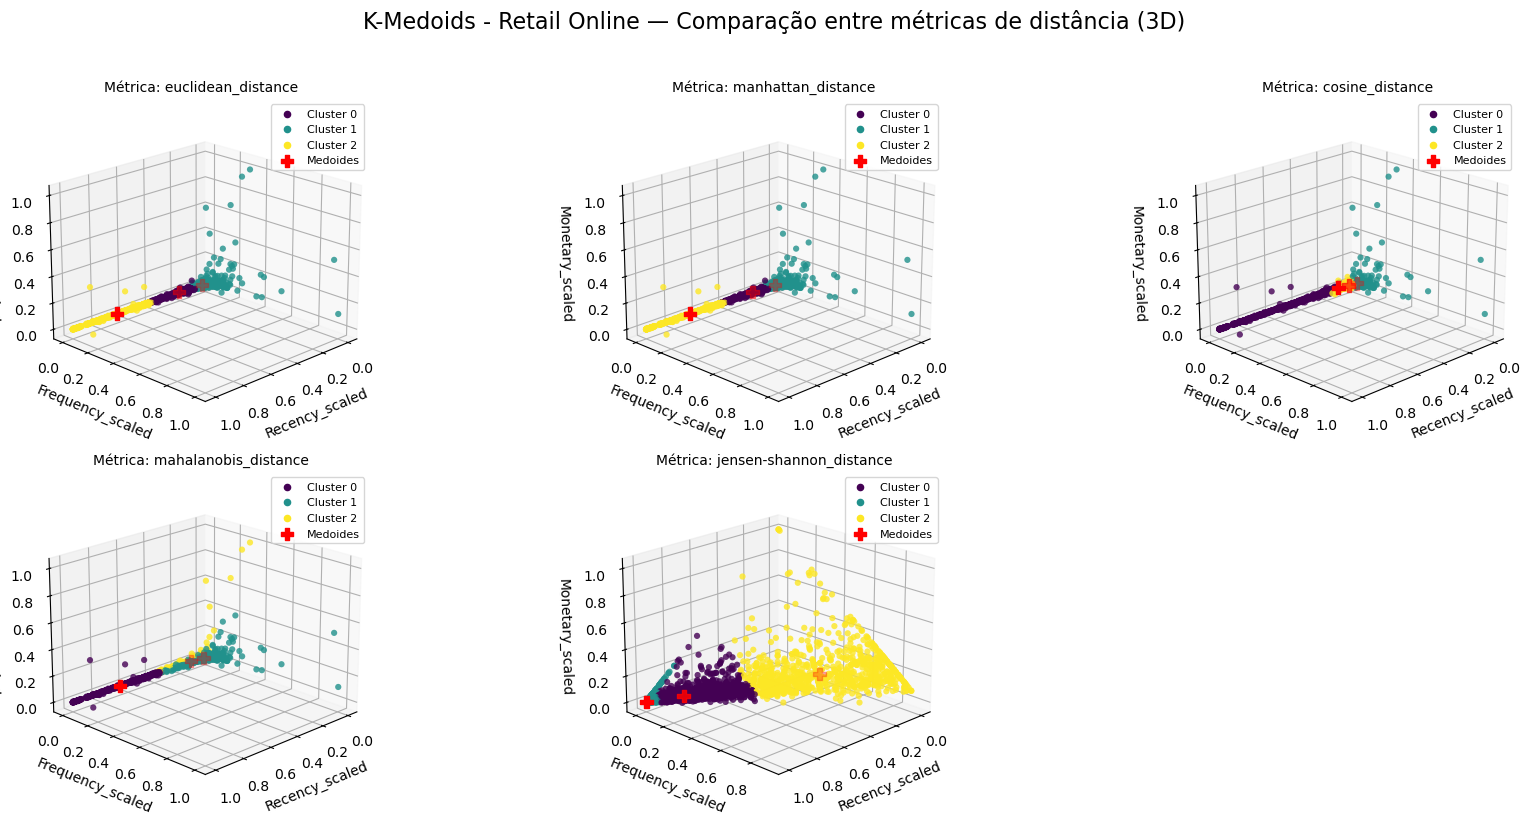

In [65]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [67]:
#results_kmedoids.pop()
df_results_kmedoids = pd.DataFrame(results_kmedoids)
df_results_kmedoids

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,KMedoids,euclidean_distance,3,126.293403,47.547266,0.560215,0.584173,12520.997170
1,KMedoids,manhattan_distance,3,108.518026,47.574333,0.559350,0.585003,12512.640186
2,KMedoids,cosine_distance,3,481.979644,247.505290,-0.104145,1.386107,654.249311
3,KMedoids,mahalanobis_distance,3,120.120823,68.771387,0.234929,1.244953,7987.855499
4,KMedoids,jensen-shannon_distance,3,2602.489784,93.432598,0.571642,0.596285,11941.176885


In [116]:
# instaciando o KMedoids
for metric_name in metrics:
    kmedoids = KMedoids(k=27, max_iterations=300, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X_jsd)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X_jsd, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X_jsd,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    else:
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    
    print(f"KMedoids com {metric_name} finalizado.")

K-Medoids convergiu na iteração 18
KMedoids com euclidean_distance finalizado.
K-Medoids convergiu na iteração 10
KMedoids com manhattan_distance finalizado.
K-Medoids convergiu na iteração 37
KMedoids com cosine_distance finalizado.
K-Medoids convergiu na iteração 29
KMedoids com mahalanobis_distance finalizado.
K-Medoids convergiu na iteração 31
KMedoids com jensen-shannon_distance finalizado.


In [66]:
labels_k_medoids_euclidean = plots_kmedoids['euclidean_distance']["labels"]
labels_k_medoids_manhattan = plots_kmedoids['manhattan_distance']["labels"]
labels_k_medoids_cosine = plots_kmedoids['cosine_distance']["labels"]
labels_k_medoids_mahalanobis = plots_kmedoids['mahalanobis_distance']["labels"]
labels_k_medoids_jsd = plots_kmedoids['jensen-shannon_distance']["labels"]

rfm_k_medoids = rfm.copy()
rfm_k_medoids[f"cluster_k_medoids_euclidean"] = labels_k_medoids_euclidean
rfm_k_medoids[f"cluster_k_medoids_manhattan"] = labels_k_medoids_manhattan
rfm_k_medoids[f"cluster_k_medoids_cosine"] = labels_k_medoids_cosine
rfm_k_medoids[f"cluster_k_medoids_mahalanobis"] = labels_k_medoids_mahalanobis
rfm_k_medoids[f"cluster_k_medoids_jsd"] = labels_k_medoids_jsd
rfm_k_medoids.head()



,Recency,Frequency,Monetary,cluster_k_medoids_euclidean,cluster_k_medoids_manhattan,cluster_k_medoids_cosine,cluster_k_medoids_mahalanobis,cluster_k_medoids_jsd
CustomerID,,,,,,,,
12346.0,326,1,77183.60,2,2,0,0,0
12347.0,2,7,4310.00,1,1,1,1,2
12348.0,75,4,1797.24,0,0,0,2,0
12349.0,19,1,1757.55,1,1,0,2,1
12350.0,310,1,334.40,2,2,0,0,1


In [68]:
cluster_profile_k_medoids_euclidean = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_euclidean")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_euclidean["perc_clientes"] = (
    cluster_profile_k_medoids_euclidean["n_clientes"] 
    / cluster_profile_k_medoids_euclidean["n_clientes"].sum()
)

cluster_profile_k_medoids_euclidean["perc_faturamento"] = (
    cluster_profile_k_medoids_euclidean["faturamento_total"] 
    / cluster_profile_k_medoids_euclidean["faturamento_total"].sum()
)

cluster_profile_k_medoids_euclidean

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_euclidean,,,,,,,,,,
1,2121,19.067421,17.0,6.495992,4.0,3310.828614,1191.13,7022267.491,0.488935,0.790154
0,1273,90.281225,79.0,2.591516,2.0,993.044699,605.12,1264145.902,0.293453,0.142243
2,944,260.649364,256.0,1.541314,1.0,636.435912,306.83,600795.501,0.217612,0.067602


In [69]:
cluster_profile_k_medoids_manhattan = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_manhattan")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_manhattan["perc_clientes"] = (
    cluster_profile_k_medoids_manhattan["n_clientes"] 
    / cluster_profile_k_medoids_manhattan["n_clientes"].sum()
)

cluster_profile_k_medoids_manhattan["perc_faturamento"] = (
    cluster_profile_k_medoids_manhattan["faturamento_total"] 
    / cluster_profile_k_medoids_manhattan["faturamento_total"].sum()
)

cluster_profile_k_medoids_manhattan

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_manhattan,,,,,,,,,,
1,2117,19.025508,17.0,6.521493,4.0,3321.350662,1207.240,7031299.351,0.488013,0.791171
0,1278,90.188576,79.0,2.561033,2.0,983.831183,599.195,1257336.252,0.294606,0.141477
2,943,260.747614,256.0,1.540827,1.0,634.754285,306.720,598573.291,0.217381,0.067352


In [70]:
cluster_profile_k_medoids_cosine = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_cosine")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_cosine["perc_clientes"] = (
    cluster_profile_k_medoids_cosine["n_clientes"] 
    / cluster_profile_k_medoids_cosine["n_clientes"].sum()
)

cluster_profile_k_medoids_cosine["perc_faturamento"] = (
    cluster_profile_k_medoids_cosine["faturamento_total"] 
    / cluster_profile_k_medoids_cosine["faturamento_total"].sum()
)

cluster_profile_k_medoids_cosine

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_cosine,,,,,,,,,,
1,550,5.345455,4.0,14.309091,10.0,8741.905473,3458.345,4808048.010,0.126787,0.541008
2,595,18.368067,16.0,6.297479,6.0,2483.790134,1789.770,1477855.130,0.137160,0.166290
0,3193,121.376135,78.0,2.165675,2.0,814.690183,454.110,2601305.754,0.736053,0.292702


In [71]:
cluster_profile_k_medoids_mahalanobis= (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_mahalanobis")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_mahalanobis["perc_clientes"] = (
    cluster_profile_k_medoids_mahalanobis["n_clientes"] 
    / cluster_profile_k_medoids_mahalanobis["n_clientes"].sum()
)

cluster_profile_k_medoids_mahalanobis["perc_faturamento"] = (
    cluster_profile_k_medoids_mahalanobis["faturamento_total"] 
    / cluster_profile_k_medoids_mahalanobis["faturamento_total"].sum()
)

cluster_profile_k_medoids_mahalanobis

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_mahalanobis,,,,,,,,,,
1,956,21.061715,13.0,11.707113,8.0,5033.366036,2705.28,4811897.930,0.220378,0.541441
2,2308,49.837522,43.0,2.416378,2.0,1460.774087,598.78,3371466.593,0.532042,0.379362
0,1074,247.917132,243.0,1.641527,1.0,655.348576,311.68,703844.371,0.247580,0.079197


In [72]:
cluster_profile_k_medoids_jsd = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_jsd")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_jsd["perc_clientes"] = (
    cluster_profile_k_medoids_jsd["n_clientes"] 
    / cluster_profile_k_medoids_jsd["n_clientes"].sum()
)

cluster_profile_k_medoids_jsd["perc_faturamento"] = (
    cluster_profile_k_medoids_jsd["faturamento_total"] 
    / cluster_profile_k_medoids_jsd["faturamento_total"].sum()
)

cluster_profile_k_medoids_jsd


,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_jsd,,,,,,,,,,
2,832,8.461538,6.0,11.894231,8.0,6826.764724,2824.91,5679868.250,0.191793,0.639106
0,1353,42.462676,32.0,4.104213,4.0,1625.836084,1093.68,2199756.222,0.311895,0.247519
1,2153,156.493730,138.0,1.431955,1.0,467.990907,322.08,1007584.422,0.496312,0.113375


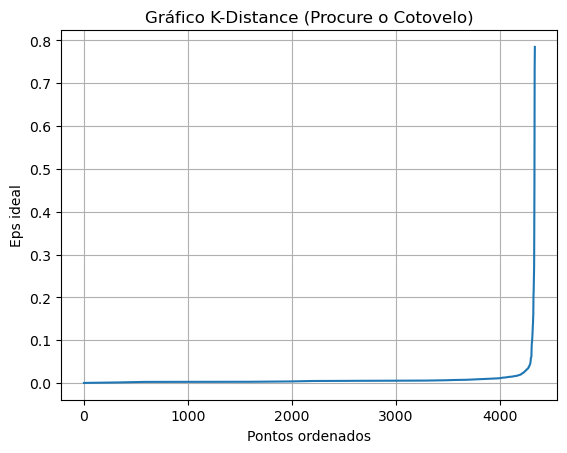

In [30]:
from sklearn.neighbors import NearestNeighbors

# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

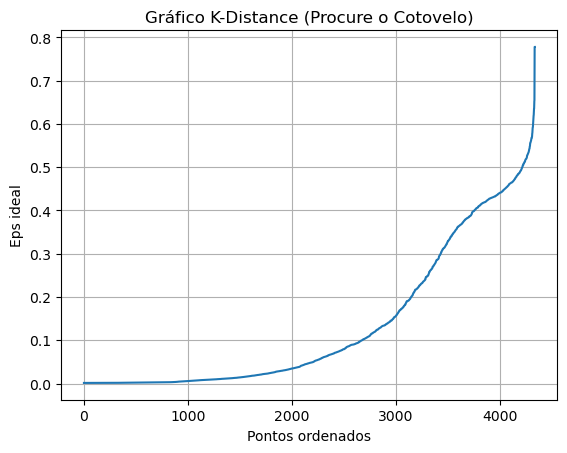

In [31]:
# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X_jsd)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

In [73]:
#Estudo do melhor eps para DBSCAN com Euclidean Distance

eval_kwargs = {}
eps = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.012, 0.015, 0.018, 0.020, 0.022, 0.025, 0.028]
results_eps = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='euclidean_distance')
    db.fit(X)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    eval_kwargs = {}
    labels_dbscan = db.labels_
    dataset = pd.concat(
            [pd.DataFrame(X_jsd), pd.DataFrame(labels_dbscan, columns=['cluster'])],
            axis=1
        )
    # filtra fora os outliers (cluster == -1)
    dataset_filtrado = dataset[dataset['cluster'] != -1]
        # separa X e y já sem ruído
    X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
    labels_inliers = np.asarray(dataset_filtrado['cluster'])
    evaluation = EvaluationMetrics(X=X_inliers, labels=labels_inliers, y_true=None, metric='euclidean', **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep
    })
    print(f"DBSCAN com eps {ep} finalizado.")

DBSCAN com eps 0.001 finalizado.
DBSCAN com eps 0.002 finalizado.
DBSCAN com eps 0.003 finalizado.
DBSCAN com eps 0.004 finalizado.
DBSCAN com eps 0.005 finalizado.
DBSCAN com eps 0.006 finalizado.
DBSCAN com eps 0.007 finalizado.
DBSCAN com eps 0.008 finalizado.
DBSCAN com eps 0.009 finalizado.
DBSCAN com eps 0.01 finalizado.
DBSCAN com eps 0.012 finalizado.
DBSCAN com eps 0.015 finalizado.
DBSCAN com eps 0.018 finalizado.
DBSCAN com eps 0.02 finalizado.
DBSCAN com eps 0.022 finalizado.
DBSCAN com eps 0.025 finalizado.
DBSCAN com eps 0.028 finalizado.


In [ ]:
df_results_eps = pd.DataFrame(results_eps)
df_results_eps

,k,sse_euclidean,silhouette,algoritmo,eps
0,27,0.081462,-0.203625,DBSCAN,0.001
1,47,0.343398,-0.212098,DBSCAN,0.002
2,62,24.517866,-0.308150,DBSCAN,0.003
3,64,42.135085,-0.407111,DBSCAN,0.004
4,45,237.023491,-0.618626,DBSCAN,0.005
5,10,316.560853,-0.543746,DBSCAN,0.006
6,12,333.754934,-0.607516,DBSCAN,0.007
7,7,396.356046,-0.565083,DBSCAN,0.008
8,3,426.693322,-0.423267,DBSCAN,0.009
9,3,432.022910,-0.422300,DBSCAN,0.010


In [77]:
#Estudo do melhor eps para DBSCAN com Euclidean Distance

eval_kwargs = {}
eps = [0.0005, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
results_eps = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='euclidean_distance')
    db.fit(X)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    eval_kwargs = {}
    labels_dbscan = db.labels_
    dataset = pd.concat(
            [pd.DataFrame(X_jsd), pd.DataFrame(labels_dbscan, columns=['cluster'])],
            axis=1
        )
    # filtra fora os outliers (cluster == -1)
    dataset_filtrado = dataset[dataset['cluster'] != -1]
        # separa X e y já sem ruído
    X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
    labels_inliers = np.asarray(dataset_filtrado['cluster'])
    evaluation = EvaluationMetrics(X=X_inliers, labels=labels_inliers, y_true=None, metric='euclidean', **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep
    })
    print(f"DBSCAN com eps {ep} finalizado.")

DBSCAN com eps 0.0005 finalizado.
DBSCAN com eps 0.004 finalizado.
DBSCAN com eps 0.005 finalizado.
DBSCAN com eps 0.006 finalizado.
DBSCAN com eps 0.007 finalizado.
DBSCAN com eps 0.008 finalizado.
DBSCAN com eps 0.009 finalizado.
DBSCAN com eps 0.01 finalizado.
DBSCAN com eps 0.02 finalizado.
DBSCAN com eps 0.03 finalizado.
DBSCAN com eps 0.04 finalizado.
DBSCAN com eps 0.05 finalizado.
DBSCAN com eps 0.06 finalizado.
DBSCAN com eps 0.07 finalizado.
DBSCAN com eps 0.08 finalizado.
DBSCAN com eps 0.09 finalizado.
DBSCAN com eps 0.1 finalizado.
DBSCAN com eps 0.15 finalizado.
DBSCAN com eps 0.2 finalizado.
DBSCAN com eps 0.25 finalizado.
DBSCAN com eps 0.3 finalizado.
DBSCAN com eps 0.35 finalizado.
DBSCAN com eps 0.4 finalizado.
DBSCAN com eps 0.45 finalizado.
DBSCAN com eps 0.5 finalizado.
DBSCAN com eps 0.55 finalizado.
DBSCAN com eps 0.6 finalizado.
DBSCAN com eps 0.65 finalizado.


In [78]:
#experimento 1
df_results_eps = pd.DataFrame(results_eps)
df_results_eps

,k,sse_euclidean,silhouette,algoritmo,eps
0,9,0.005294,-0.041831,DBSCAN,0.0005
1,64,42.135085,-0.407111,DBSCAN,0.0040
2,45,237.023491,-0.618626,DBSCAN,0.0050
3,10,316.560853,-0.543746,DBSCAN,0.0060
4,12,333.754934,-0.607516,DBSCAN,0.0070
5,7,396.356046,-0.565083,DBSCAN,0.0080
6,3,426.693322,-0.423267,DBSCAN,0.0090
7,3,432.022910,-0.422300,DBSCAN,0.0100
8,2,536.866506,-0.454158,DBSCAN,0.0200
9,1,570.768201,NaN,DBSCAN,0.0300


In [79]:
#Estudo do melhor eps para DBSCAN com Euclidean Distance

eval_kwargs = {}
eps = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005]
results_eps = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='euclidean_distance')
    db.fit(X)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    eval_kwargs = {}
    labels_dbscan = db.labels_
    dataset = pd.concat(
            [pd.DataFrame(X_jsd), pd.DataFrame(labels_dbscan, columns=['cluster'])],
            axis=1
        )
    # filtra fora os outliers (cluster == -1)
    dataset_filtrado = dataset[dataset['cluster'] != -1]
        # separa X e y já sem ruído
    X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
    labels_inliers = np.asarray(dataset_filtrado['cluster'])
    evaluation = EvaluationMetrics(X=X_inliers, labels=labels_inliers, y_true=None, metric='euclidean', **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep
    })
    print(f"DBSCAN com eps {ep} finalizado.")

DBSCAN com eps 1e-05 finalizado.
DBSCAN com eps 2e-05 finalizado.
DBSCAN com eps 3e-05 finalizado.
DBSCAN com eps 4e-05 finalizado.
DBSCAN com eps 5e-05 finalizado.


In [80]:

df_results_eps = pd.DataFrame(results_eps)
df_results_eps

,k,sse_euclidean,silhouette,algoritmo,eps
0,0,0.0,NaN,DBSCAN,0.00001
1,0,0.0,NaN,DBSCAN,0.00002
2,0,0.0,NaN,DBSCAN,0.00003
3,0,0.0,NaN,DBSCAN,0.00004
4,0,0.0,NaN,DBSCAN,0.00005


In [111]:
results_dbscan = []
plots_dbscan = {}

### Algoritmo: DBSCAN

In [112]:
# instaciando o DBSCAN
for metric_name in metrics:
    if metric_name == 'jensen-shannon_distance':
        dbscan = DBSCAN(eps=0.001, min_samples=10, metric=metric_name)
        t0 = time()
        dbscan.fit(X_jsd)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        # Máscara para remover outliers
        mask_inliers = labels_dbscan != -1
        X_inliers = X_jsd[mask_inliers]
        labels_inliers = labels_dbscan[mask_inliers]
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X_inliers, labels=labels_inliers))
        plots_dbscan[metric_name] = {
            "X": X_jsd,
            "labels": labels_dbscan,
            "model": dbscan
        }
    else:
        dbscan = DBSCAN(eps=0.001, min_samples=10, metric=metric_name)
        t0 = time()
        dbscan.fit(X)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        # Máscara para remover outliers
        mask_inliers = labels_dbscan != -1
        X_inliers = X[mask_inliers]
        labels_inliers = labels_dbscan[mask_inliers]
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X_inliers, labels=labels_inliers))
        plots_dbscan[metric_name] = {
            "X": X,
            "labels": labels_dbscan,
            "model": dbscan
        }
    
    print(f"dbscan com {metric_name} finalizado.")

dbscan com euclidean_distance finalizado.
dbscan com manhattan_distance finalizado.
dbscan com cosine_distance finalizado.
dbscan com mahalanobis_distance finalizado.
dbscan com jensen-shannon_distance finalizado.


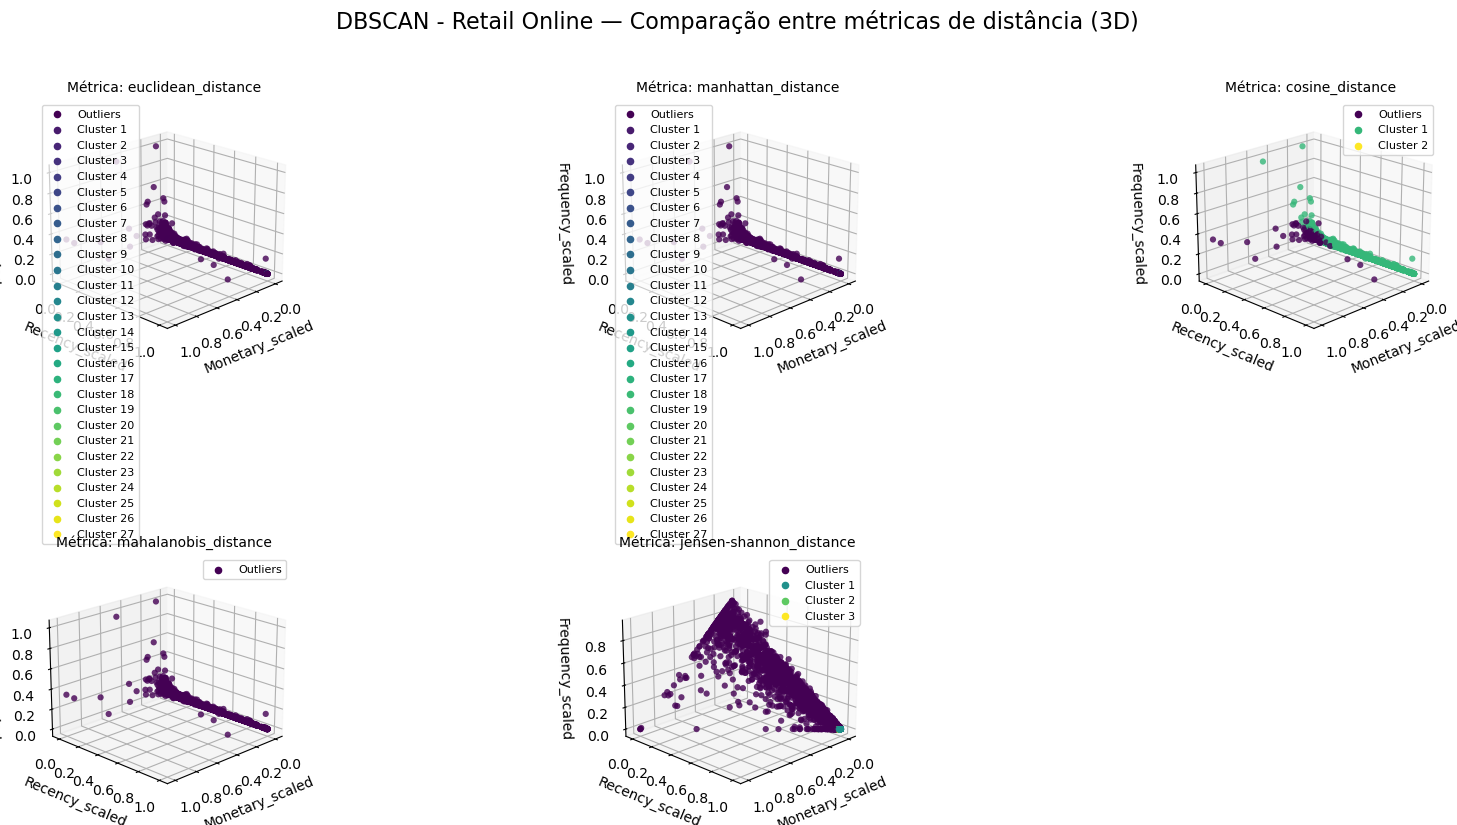

In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_dbscan, algorithm_name="DBSCAN - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [114]:
#results_dbscan.pop()
df_results_dbscan = pd.DataFrame(results_dbscan)
df_results_dbscan

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,euclidean_distance,27,61.757658,0.000078,0.855915,0.200894,3.165801e+06
1,DBSCAN,manhattan_distance,27,76.615494,0.000078,0.855915,0.200894,3.165801e+06
2,DBSCAN,cosine_distance,2,257.345150,305.402087,-0.332187,1.058895,6.928663e+00
3,DBSCAN,mahalanobis_distance,0,79.538903,0.000000,NaN,NaN,NaN
4,DBSCAN,jensen-shannon_distance,3,1056.485578,0.028666,0.638226,0.288051,5.497383e+02


In [119]:

linhas = []

for nome_teste, info in plots_dbscan.items():
    labels = np.asarray(info["labels"])
    modelo = info["model"]

    n_pontos = len(labels)
    n_outliers = np.sum(labels == -1)
    perc_outliers = n_outliers / n_pontos

    # número de clusters válidos (sem contar -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    linhas.append({
        "teste": nome_teste,                    # ex.: "euclidean_distance" ou "euclidean_eps_0.01"
        "eps": getattr(modelo, "eps", None),
        "min_samples": getattr(modelo, "min_samples", None),
        "n_pontos": n_pontos,
        "n_outliers": n_outliers,
        "perc_outliers": perc_outliers,
        "n_clusters": n_clusters,
    })

df_outliers = pd.DataFrame(linhas).sort_values("perc_outliers", ascending=False)
df_outliers


,teste,eps,min_samples,n_pontos,n_outliers,perc_outliers,n_clusters
3,mahalanobis_distance,0.001,10,4338,4338,1.000000,0
0,euclidean_distance,0.001,10,4338,4015,0.925542,27
1,manhattan_distance,0.001,10,4338,4015,0.925542,27
4,jensen-shannon_distance,0.001,10,4338,3012,0.694329,3
2,cosine_distance,0.001,10,4338,222,0.051176,2


### Algoritmo: EM

In [139]:
results_em = []
plots_em = {}
# instaciando the Expectation Maximization
for metric_name in metrics:
    em = ExpectationMaximization(n_clusters=2, max_iterations=10000, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        em.fit(X_jsd)
        runtime_em = time() - t0
        labels_em = em.labels_
        results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X_jsd, labels=labels_em))
        plots_em[metric_name] = {
            "X": X_jsd,
            "labels": labels_em,
            "model": em
        }
    else:
        t0 = time()
        em.fit(X)
        runtime_em = time() - t0
        labels_em = em.labels_
        results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))
        plots_em[metric_name] = {
            "X": X,
            "labels": labels_em,
            "model": em
        }
    print(f"Expectation Maximization com métrica {metric_name} finalizado.")


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


Expectation Maximization com métrica euclidean_distance finalizado.
Expectation Maximization com métrica manhattan_distance finalizado.
Expectation Maximization com métrica cosine_distance finalizado.
Expectation Maximization com métrica mahalanobis_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


Expectation Maximization com métrica jensen-shannon_distance finalizado.


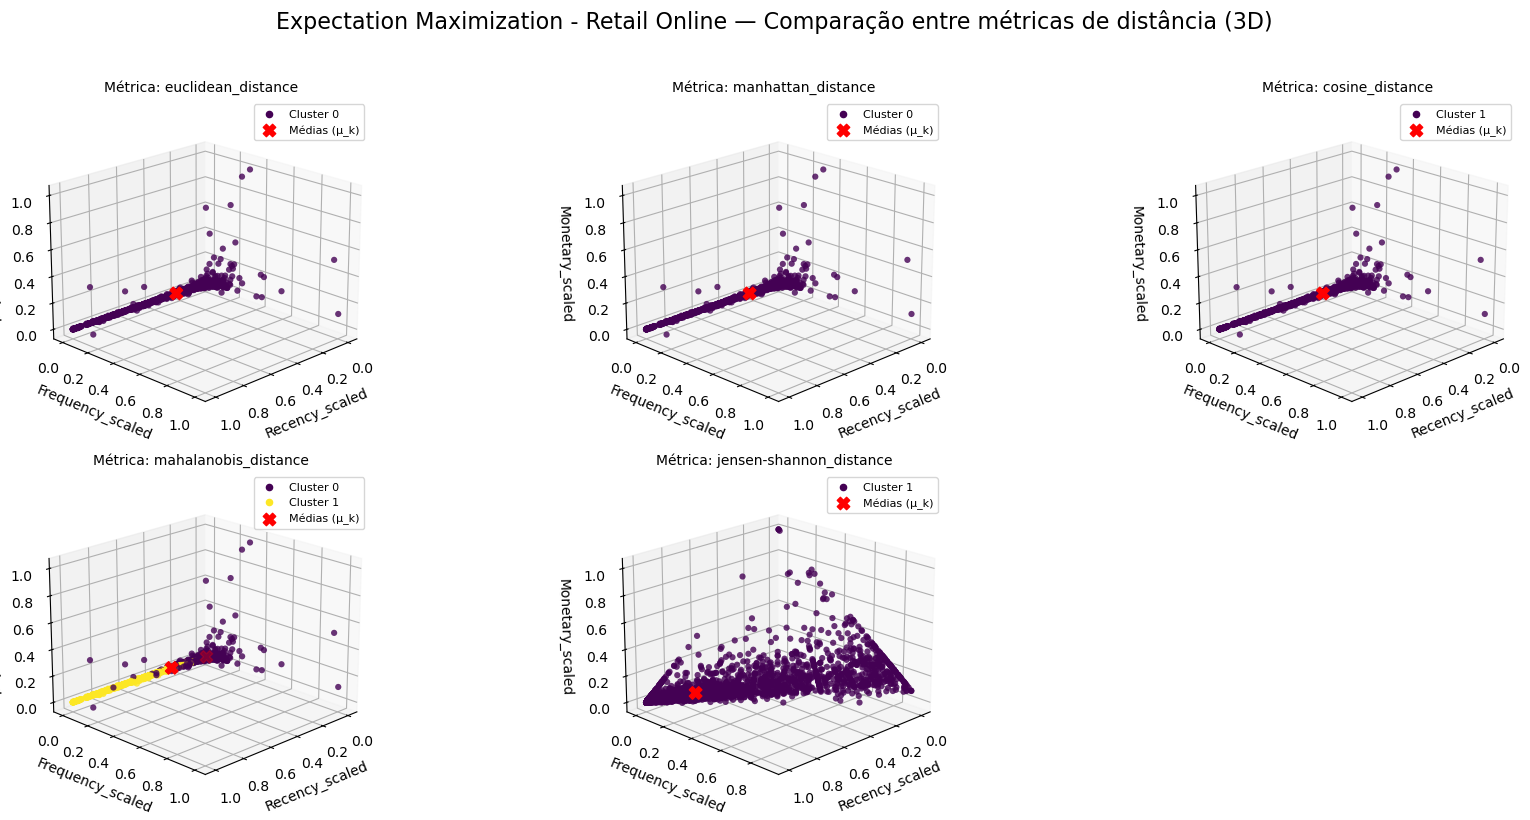

In [140]:
plot_algorithm_all_metrics_3d(plot_dict=plots_em, algorithm_name="Expectation Maximization - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [141]:
#results_em.pop()
df_results_em = pd.DataFrame(results_em)
df_results_em

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Expectation Maximization,euclidean_distance,1,0.295809,322.213555,NaN,NaN,NaN
1,Expectation Maximization,manhattan_distance,1,0.325051,322.213555,NaN,NaN,NaN
2,Expectation Maximization,cosine_distance,1,0.234528,322.213555,NaN,NaN,NaN
3,Expectation Maximization,mahalanobis_distance,2,0.044717,297.095075,-0.079088,1.398556,366.595537
4,Expectation Maximization,jensen-shannon_distance,1,3.273777,608.170856,NaN,NaN,NaN


### Algoritmo: Ward

In [ ]:
results_ward = []
plots_ward = {}
# instaciando the Ward Method
for metric_name in metrics:
    ward = WardMethod(k=3, metric=metric_name)
    t0 = time()
    labels_ward = ward.fit_predict(X)
    runtime_ward = time() - t0
    results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))
    plots_ward[metric_name] = {
        "X": X,
        "labels": labels_ward,
        "model": ward
    }
    print(f"Ward Method com métrica {metric_name} finalizado.")

#Jensen-Shannon Distance vai usar um X diferente
ward = WardMethod(k=3, metric='jensen-shannon_distance')
t0 = time()
labels_ward = ward.fit_predict(X_jsd)
runtime_ward = time() - t0
results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name='jensen-shannon_distance', runtime=runtime_ward, X=X_jsd, labels=labels_ward))
plots_ward['jensen-shannon_distance'] = {
        "X": X_jsd,
        "labels": labels_ward,
        "model": ward
    }
print(f"Ward Method com métrica jensen-shannon_distance finalizado.")

In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [ ]:
#results_ward.pop()
df_results_ward = pd.DataFrame(results_ward)
df_results_ward

In [ ]:
ward_euc = plots_ward["euclidean_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["manhattan_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["mahalanobis_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["cosine_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["jensen-shannon_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)